<a href="https://colab.research.google.com/github/LyndainesSantos/detection_methods/blob/main/q03_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

## Análise do banco de dados

In [ ]:
# import das libs
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Carregar o dataset como DataFrame
df = pd.read_csv('StanfordCarsDatasetCSV-main/cardatasettrain.csv')
df

,Unnamed: 0,x1,y1,x2,y2,Class,image
0,0,39,116,569,375,14,00001.jpg
1,1,36,116,868,587,3,00002.jpg
2,2,85,109,601,381,91,00003.jpg
3,3,621,393,1484,1096,134,00004.jpg
4,4,14,36,133,99,106,00005.jpg
...,...,...,...,...,...,...,...
8139,8139,3,44,423,336,78,08140.jpg
8140,8140,138,150,706,523,196,08141.jpg
8141,8141,26,246,660,449,163,08142.jpg
8142,8142,78,526,1489,908,112,08143.jpg


In [ ]:
# Excluir uma das colunas que indica o index (neste caso, é desnecessário, pois o dataframe já possui index automático)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Cópia do dataset
dataset = df.copy()
dataset.head()

,x1,y1,x2,y2,Class,image
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg


In [ ]:
# Filtrar dentre as 196 classes, somente as classes 3, 4, 5 e 6 (classe indefinida)
dataset = dataset[dataset['Class'].isin([3,4,5,6])]
dataset.head()

,x1,y1,x2,y2,Class,image
1,36,116,868,587,3,00002.jpg
68,142,124,675,445,5,00069.jpg
150,8,37,294,150,5,00151.jpg
197,91,121,574,357,6,00198.jpg
254,29,78,734,396,6,00255.jpg


In [ ]:
# Agrupamento do nº de observações por classes
dataset_distribution = dataset['Class'].value_counts()
dataset_distribution

6    45
3    43
4    42
5    41
Name: Class, dtype: int64

### Visualização do agrupamento

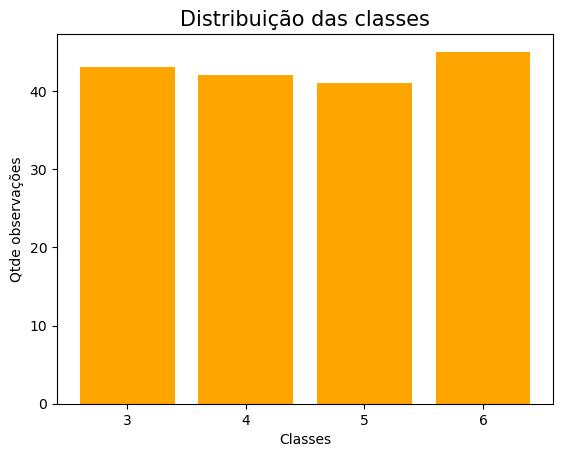

In [ ]:
plt.bar(dataset_distribution.index, dataset_distribution.values, color='orange')
plt.title('Distribuição das classes', size = 15)
plt.xlabel('Classes')
plt.ylabel('Qtde observações')
plt.xticks(dataset_distribution.index)
plt.show()

In [ ]:
# Subsituição para 'classe indefinida'
dataset['Class'].replace(6, 'classe indefinida', inplace=True)
dataset.head()

,x1,y1,x2,y2,Class,image
1,36,116,868,587,3,00002.jpg
68,142,124,675,445,5,00069.jpg
150,8,37,294,150,5,00151.jpg
197,91,121,574,357,classe indefinida,00198.jpg
254,29,78,734,396,classe indefinida,00255.jpg


### Salvar arquivo .csv

In [ ]:
dataset.to_csv('dataset_cars.csv', index=False)

# CNN (Convolutional neural network)

### Instalação tensorflow

In [ ]:
!pip install tensorflow

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from PIL import Image

In [ ]:
# Caminho para a pasta de imagens
path = './dataset_bmw/cars_train/'
# Tamanho fixo para redimensionamento da imagem
image_size = (128, 128)
# Carregar o dataset
dataset = pd.read_csv('dataset_cars.csv')

In [ ]:
# Visualização do DataFrame
dataset.head()

,x1,y1,x2,y2,Class,image
0,36,116,868,587,3,00002.jpg
1,142,124,675,445,5,00069.jpg
2,8,37,294,150,5,00151.jpg
3,91,121,574,357,classe indefinida,00198.jpg
4,29,78,734,396,classe indefinida,00255.jpg


In [ ]:
# Ler as classes presentes no dataset
class_names = list(dataset['Class'].unique())
class_names

['3', '5', 'classe indefinida', '4']

In [ ]:
# Recortar de acordo com as coords bbox e redimensionar as imagens
def crop_and_resize_image(img_path, bbox_x1, bbox_x2, bbox_y1, bbox_y2, image_size):
    img = Image.open(img_path)
    cropped_img = img.crop((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
    resized_img = cropped_img.resize(image_size)
    return np.array(resized_img)

In [ ]:
def criar_images_bbox_labels(dataset, path_data, img_size):
    # Criar lista de imagens e labels
    images = []
    labels = []

    for index, row in dataset.iterrows():
        image_path = os.path.join(path_data, row['image'])
        resized_img = crop_and_resize_image(image_path, row['x1'], row['x2'], row['y1'], row['y2'], img_size)
        images.append(resized_img)
        labels.append(row['Class'])

        # Convertendo as listas para arrays numpy
    images = np.array(images)
    labels = np.array(labels)

        # Codificar labels para números inteiros
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

        # Normalizar as imagens
    images = images / 255.0

    return images, labels

In [ ]:
def training_model(img_size, cls, evaluate=True):
    # Construir o modelo CNN
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(cls), activation='softmax')
    ])

    # Compilar o modelo
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    if evaluate == True:
        evaluate_model(model)

    return

In [ ]:
def evaluate_model(model):
    # Avaliar o modelo
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')

In [ ]:
img_list, label_list = criar_images_bbox_labels(dataset, path, image_size)

In [ ]:
# Divisão em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(img_list, label_list, train_size=0.7, random_state=42)

In [ ]:
model = training_model(image_size, class_names)

Epoch 1/10


C:\Users\Lynda\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.2195 - loss: 4.4574 - val_accuracy: 0.1731 - val_loss: 2.1497
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.2728 - loss: 1.6933 - val_accuracy: 0.2115 - val_loss: 1.4357
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.5248 - loss: 1.2902 - val_accuracy: 0.3654 - val_loss: 1.3122
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.4357 - loss: 1.1980 - val_accuracy: 0.5577 - val_loss: 1.2263
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.8928 - loss: 0.9930 - val_accuracy: 0.4231 - val_loss: 1.2286
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.8037 - loss: 0.7658 - val_accuracy: 0.4038 - val_loss: 1.3591
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8593 - loss: 0.5387 - val_accuracy: 0.5577 - val_loss: 1.0491
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.9304 - loss: 0.3565 - val_accuracy: 0.4615 - val_loss: 1.4466
Epo